# Excercise: MedMCQA Dataset

*MedMCQA dataset description*

MedMCQA is a large-scale, Multiple-Choice Question Answering (MCQA) dataset designed to address real-world medical entrance exam questions.

MedMCQA has more than 194k high-quality AIIMS & NEET PG entrance exam MCQs covering 2.4k healthcare topics and 21 medical subjects are collected with an average token length of 12.77 and high topical diversity.

Each sample contains a question, correct answer(s), and other options which require a deeper language understanding as it tests the 10+ reasoning abilities of a model across a wide range of medical subjects, including the followings:
Anesthesia, Anatomy, Biochemistry, Dental, ENT, Forensic Medicine (FM), Obstetrics and Gynecology (O&G), Medicine, Microbiology, Ophthalmology, Orthopedics, Pathology, Pediatrics, Pharmacology, Physiology, Psychiatry, Radiology, Skin, Preventive & Social Medicine (PSM), Surgery.

More information in Reference: https://huggingface.co/datasets/openlifescienceai/medmcqa

*Exercise Description*

**Objective**: Use gemma3:12b (or any other model from Ollama) to answer questions from the MedMCQA dataset, based on the following guidelines.
- **Subjects to Include**: Focus on questions related to the following subjects: Dental, Pathology, Surgery, Medicine, Anaesthesia, and Radiology.
- **Scope**: limited to validation dataset.
- **Evaluation Metrics**: 
1. Overall accuracy.
2. Accuracy per subject.



# Imports

In [1]:
import os
import pprint
import tqdm
from datasets import load_dataset
import time
import pandas as pd
import matplotlib.pyplot as plt
import json
import ollama
from concurrent.futures import ThreadPoolExecutor
from ollama import chat
# import seaborn as sns

## Getting Started: Ollama

In [2]:
## pull model deepseek-r1 if it does not exist (run <!ollama list> to check if available)
# !ollama list  --- check list of models available 
# e.g., !ollama pull gemma3:12b --- to pull gemma3:12b
# !ollama pull gemma3:12b

In [3]:
#  Prompt/User input
query = 'Tell me a joke'
message = [
  {"role": "system", "content": "You are a helpful AI assistant."}, 
  {"role": "user", "content": f"{query}"}
]

In [4]:
## Submit your request
model_id = 'gemma3:12b'
response = chat(model=model_id, messages=message)
print(response.message.content)

Why don't scientists trust atoms?

Because they make up everything! 😂 

Hope that gave you a chuckle! 😊


# Data Loading and Preprocessing

In [5]:
## Load dataset
# https://huggingface.co/datasets/openlifescienceai/medmcqa
# Login using e.g. `huggingface-cli login` to access this dataset

data= load_dataset("openlifescienceai/medmcqa")

## to preview the data
data


DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 182822
    })
    test: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 6150
    })
    validation: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 4183
    })
})

In [6]:
## Convert validation dataset to dataframe
data = data['validation'].to_pandas()
data.head()

## print data shape
pprint.pprint(data.shape)


(4183, 11)


In [7]:

## show questions types
pprint.pprint(data['choice_type'].value_counts())


## show count of subjects
pprint.pprint(data['subject_name'].value_counts())


## Filter the dataset by:
# Single questions
data = data[data.choice_type =='single']


# Subject_names : [ 'Dental', 'Pathology','Surgery', 'Medicine', 'Anaesthesia', 'Radiology']
subject_names = [ 'Dental', 'Pathology','Surgery', 'Medicine', 'Anaesthesia', 'Radiology']
data = data[data.subject_name.isin(subject_names)]


# Show final data shape
data.reset_index(inplace=True, drop=True)
data.shape
pprint.pprint(data.shape)


choice_type
single    2816
multi     1367
Name: count, dtype: int64
subject_name
Dental                          1318
Surgery                          369
Pathology                        337
Medicine                         295
Pharmacology                     243
Pediatrics                       234
Anatomy                          234
Gynaecology & Obstetrics         224
Physiology                       171
Biochemistry                     171
Social & Preventive Medicine     129
Microbiology                     122
Radiology                         69
Forensic Medicine                 67
Ophthalmology                     58
ENT                               53
Anaesthesia                       34
Orthopaedics                      20
Skin                              17
Psychiatry                        16
Unknown                            2
Name: count, dtype: int64
(1619, 11)


# Inference

In [8]:
## Helper functions to prapare data for inference

def generate_message(query):

    """
    Constructs a message for an AI assistant to answer a medical multiple-choice question.

    The function returns a list of messages formatted for use with chat-based language models
    (e.g., OpenAI's GPT API), setting the assistant's role and providing context with an example.

    The assistant is instructed to act as a medical doctor and select the correct answer from 
    the given choices (A to D) without explanation.

    Parameters:
        query (str): The medical multiple-choice question formatted with options.

    Returns:
        list: A list of dictionaries representing the chat message history. It includes:
            - A system message with detailed instructions and an example format.
            - A user message containing the input query.
    """
    instruction = '''You are a medical doctor answering real-world medical entrance exam questions. Based on your understanding of basic and clinical science, medical knowledge, and mechanisms underlying health, disease, patient care, and modes of therapy, answer the following multiple-choice question. Select one correct answer from A to D. Do not provide reasons. Only the letter of the correct answer. Follow the example below.'''

    example = '''Question: Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma:
    (A) Hyperplasia
    (B) Hyperophy
    (C) Atrophy
    (D) Dyplasia
    Answer: C'''


    message = [
    {"role": "system", "content": f"You are a helpful AI assistant. {instruction} \n\n Example:\n\n{example}"}, 
    {"role": "user", "content": f"{query}"}
    ]
    return message

def create_query(x):

    """
    Formats a dictionary containing a medical question and answer choices into a structured prompt.

    The function accepts a dictionary with a question and four options, and returns a string 
    formatted as a multiple-choice question, suitable for passing to a language model.

    Parameters:
        x (dict): A dictionary with the following keys:
            - 'question' (str): The question text.
            - 'opa' (str): Option A.
            - 'opb' (str): Option B.
            - 'opc' (str): Option C.
            - 'opd' (str): Option D.

    Returns:
        str: A formatted multiple-choice question string with options labeled (A) to (D).
    """

    question = x['question']
    option_A = x['opa']
    option_B = x['opb']
    option_C = x['opc']
    option_D =  x['opd']
    prompt = f'''Question: {question}
    (A) {option_A}
    (B) {option_B}
    (C) {option_C}
    (D) {option_D}
    '''
    
    return prompt

##  Example (1 sample)


In [9]:

## Step 1. Create query
example = data.iloc[0] ## first sample/row/question
query = create_query(example)
## show the query
pprint.pprint(query)

## Step 2. Generate message
message  = generate_message(query)
## show the message
pprint.pprint(message)


## Step 3. Submit request
response = chat(model=model_id, messages=message)

## show the model answer
print(response.message.content)

('Question: A 29 yrs old woman with a pregnancy of 17 week has a 10 years old '
 'boy with down syndrome. She does not want another down syndrome kid; best '
 'advice to her is\n'
 '    (A) No test is required now as her age is below 35 years\n'
 '    (B) Ultra sound at this point of time will definitely tell her that next '
 'baby will be down syndromic or not\n'
 '    (C) Amniotic fluid samples plus chromosomal analysis will definitely '
 'tell her that next baby will be down syndromic or not\n'
 '    (D) blood screening at this point of time will clear the exact picture\n'
 '    ')
[{'content': 'You are a helpful AI assistant. You are a medical doctor '
             'answering real-world medical entrance exam questions. Based on '
             'your understanding of basic and clinical science, medical '
             'knowledge, and mechanisms underlying health, disease, patient '
             'care, and modes of therapy, answer the following multiple-choice '
             'question.

## Full Dataset

In [10]:
model_id

'gemma3:12b'

In [11]:
## Step 1. Create queries
data['query'] = data.apply(create_query,axis=1)

## Step 2. Generate messages
queries = data['query'].values
messages = [generate_message(query) for query in queries]

## Step 3. Submit requests and save results
def get_ollama_response(message, model_name = model_id):
    response = ollama.chat(
        model=model_name,
        messages=message
    )
    return response['message']['content']


start_time = time.time()
with ThreadPoolExecutor(max_workers=4) as executor: # Adjust max_workers as needed
    outputs = list(executor.map(get_ollama_response, messages))

end_time = time.time()
total_time = end_time - start_time
print(f"Execution time: {end_time - start_time:.4f} seconds")
    


Execution time: 180.8905 seconds


In [12]:
## step 4 save results
responses = {}
for id_, response in zip( data['id'].values,outputs):
    responses[id_] = response

In [13]:
# optional
# Save data to a JSON file
with open("o2-demo-LLMresponses.json", "w") as json_file:
    json.dump(responses, json_file, indent=4) 

# Response processing and performance evaluation

In [14]:
# Response processing

# Parse the model answer.
def extract_answer(x):
    x = x.lower()
    x = x.replace('answer:', '')
    return x.strip()

parsed_answers= {}
for id_ in responses:
    parsed_answers[id_] =extract_answer(responses[id_])
data[f'pred_{model_id}'] = data['id'].map(parsed_answers)

## Performance Evaluation

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619 entries, 0 to 1618
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1619 non-null   object
 1   question         1619 non-null   object
 2   opa              1619 non-null   object
 3   opb              1619 non-null   object
 4   opc              1619 non-null   object
 5   opd              1619 non-null   object
 6   cop              1619 non-null   int64 
 7   choice_type      1619 non-null   object
 8   exp              529 non-null    object
 9   subject_name     1619 non-null   object
 10  topic_name       99 non-null     object
 11  query            1619 non-null   object
 12  pred_gemma3:12b  1619 non-null   object
dtypes: int64(1), object(12)
memory usage: 164.6+ KB


In [16]:
## overall accuracy
def  compute_accuracy(y_pred, y_true):
    count=0
    for y, yi in zip(y_pred, y_true):
        if y==yi:
            count +=1
    return count/len(y_true)

## map prediction to 0,1,2,4
labels2ids_dict= {'a': int(0), 'b': int(1), 'c': int(2), 'd': int(3)}
data[f'pred_{model_id}'] = data[f'pred_{model_id}'].map(labels2ids_dict)

# Step 7. Compute overall accuracy

y_true = data['cop'] ### answer of the question, as per the dataset
y_pred = data[f'pred_{model_id}'] 
overall_accuracy = compute_accuracy(y_pred, y_true)
print (f'Overall accuracy of {model_id}: {overall_accuracy}')

Overall accuracy of gemma3:12b: 0.5336627547869055


In [17]:
## Field Accuracy
subject_names = [ 'Dental', 'Pathology','Surgery', 'Medicine', 'Anaesthesia', 'Radiology'] 
subject_accuracy = {}
for subject in subject_names:
    X = data[data['subject_name']== subject]
    y_true = X['cop']
    y_pred = X[f'pred_{model_id}']
    subject_accuracy[subject] = compute_accuracy(y_true, y_pred)
df_subjectAccuracies = pd.DataFrame( {model_id: subject_accuracy})


In [18]:
## show performance
df_subjectAccuracies['Subject'] = df_subjectAccuracies.index
print (df_subjectAccuracies)

             gemma3:12b      Subject
Dental         0.476923       Dental
Pathology      0.660232    Pathology
Surgery        0.534137      Surgery
Medicine       0.600000     Medicine
Anaesthesia    0.458333  Anaesthesia
Radiology      0.614035    Radiology


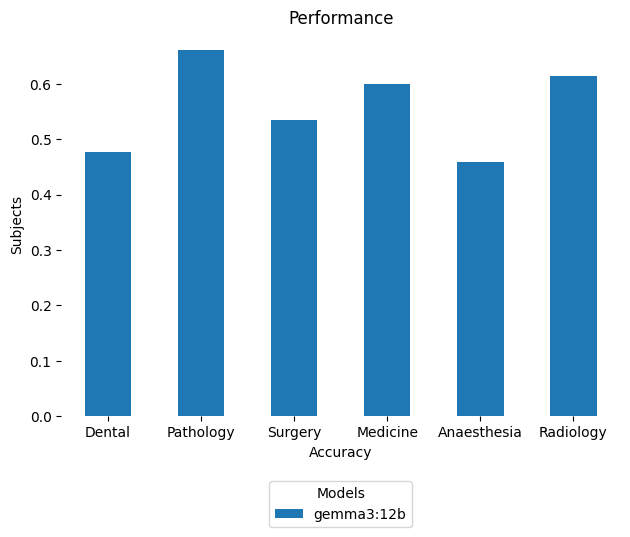

In [19]:
# Plot bar chart
ax = df_subjectAccuracies.plot(kind='bar')  # each column is hue, each index is category
plt.xlabel("Accuracy")
plt.ylabel("Subjects")
plt.title("Performance")
plt.xticks(rotation= 'horizontal')
plt.tight_layout()
# Remove all spines (frames)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.legend(title="Models", bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)  # Adjust legend position
plt.show();